In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick

## Connect to GCP

In [3]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    project_id = "project-id"
    os.environ["GOOGLE_CLOUD_PROJECT"] = project_id
except:
    pass

## Bronze Layer

To determine whether a user churns in a certain membership plan or not, only the transactions dataset will be used. Therefore, in the label engineering part, only transactions.csv will be processed to follow the medallion architecture. Other tables will be processed in the feature engineering part.

In [70]:
### Ingesting data from Google Cloud Storage
bucket_name = "cs611_mle"
transactions_path_in_bucket = "Data Source/transactions.csv"
transactions_gcs_path = f"gs://{bucket_name}/{transactions_path_in_bucket}"

df_transactions = pd.read_csv(transactions_gcs_path)

In [5]:
print(f"transactions.shape: {df_transactions.shape}")

transactions.shape: (3406383, 10)


In [6]:
print("---------------transactions.information---------------")
print(df_transactions.info())

---------------transactions.information---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3406383 entries, 0 to 3406382
Data columns (total 10 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   Unnamed: 0              int64 
 1   msno                    object
 2   payment_method_id       int64 
 3   payment_plan_days       int64 
 4   plan_list_price         int64 
 5   actual_amount_paid      int64 
 6   is_auto_renew           int64 
 7   transaction_date        int64 
 8   membership_expire_date  int64 
 9   is_cancel               int64 
dtypes: int64(9), object(1)
memory usage: 259.9+ MB
None


In [ ]:
# Create bronze tables and store to Google Cloud Storage
bronze_transactions_file_path = "Bronze Layer/bronze_transactions.csv"
bronze_transactions_gcs_path = f"gs://{bucket_name}/{bronze_transactions_file_path}"

try:
    df_transactions.to_csv(bronze_transactions_gcs_path, index=False)
    print("bronze_transactions.csv Stored to Bronze Layer Successfully! ✅")
except Exception as e:
    print(f"bronze_transactions.csv Store Failed: {e}")

## Silver Layer

In [ ]:
df_transactions = df_transactions.drop(columns=["Unnamed: 0"])
df_transactions['transaction_date'] = pd.to_datetime(df_transactions['transaction_date'], format='%Y%m%d')
df_transactions['membership_expire_date'] = pd.to_datetime(df_transactions['membership_expire_date'], format='%Y%m%d')
df_transactions = df_transactions.sort_values(by=['msno', 'transaction_date', 'membership_expire_date'])

In [9]:
df_transactions.isna().sum()

,0
msno,0
payment_method_id,0
payment_plan_days,0
plan_list_price,0
actual_amount_paid,0
is_auto_renew,0
transaction_date,0
membership_expire_date,0
is_cancel,0


In [10]:
df_transactions.describe()

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
count,3.406383e+06,3.406383e+06,3.406383e+06,3.406383e+06,3.406383e+06,3406383,3406383,3.406383e+06
mean,3.939665e+01,3.155030e+01,1.446823e+02,1.473133e+02,9.215306e-01,2016-02-27 22:07:30.980878336,2016-04-16 20:53:10.746314496,5.578380e-02
min,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2015-01-01 00:00:00,1970-01-01 00:00:00,0.000000e+00
25%,3.900000e+01,3.000000e+01,1.290000e+02,1.290000e+02,1.000000e+00,2015-08-07 00:00:00,2015-09-27 00:00:00,0.000000e+00
50%,4.100000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2016-02-28 00:00:00,2016-04-23 00:00:00,0.000000e+00
75%,4.100000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2016-09-27 00:00:00,2016-11-10 00:00:00,0.000000e+00
max,4.100000e+01,4.500000e+02,2.000000e+03,2.000000e+03,1.000000e+00,2017-03-31 00:00:00,2023-08-17 00:00:00,1.000000e+00
std,3.097484e+00,2.936009e+01,1.253914e+02,1.246733e+02,2.689089e-01,NaN,NaN,2.295038e-01


In [11]:
daily_transactions_by_user = df_transactions.groupby(['msno', 'transaction_date', 'is_cancel']).size().reset_index(name='transaction_count')
daily_transactions_by_user = daily_transactions_by_user.sort_values(by = 'transaction_count', ascending = False)
daily_user_counts_by_transactions = daily_transactions_by_user.groupby(['transaction_count']).size().reset_index(name = 'counts')
daily_user_counts_by_transactions['cumsum'] = daily_user_counts_by_transactions['counts'].cumsum()
daily_user_counts_by_transactions['proportion'] = daily_user_counts_by_transactions['cumsum']/daily_user_counts_by_transactions['counts'].sum()
daily_user_counts_by_transactions

,transaction_count,counts,cumsum,proportion
0,1,3349080,3349080,0.991825
1,2,26563,3375643,0.999692
2,3,758,3376401,0.999916
3,4,148,3376549,0.999960
4,5,44,3376593,0.999973
5,6,31,3376624,0.999983
6,7,8,3376632,0.999985
7,8,9,3376641,0.999988
8,9,5,3376646,0.999989
9,10,6,3376652,0.999991


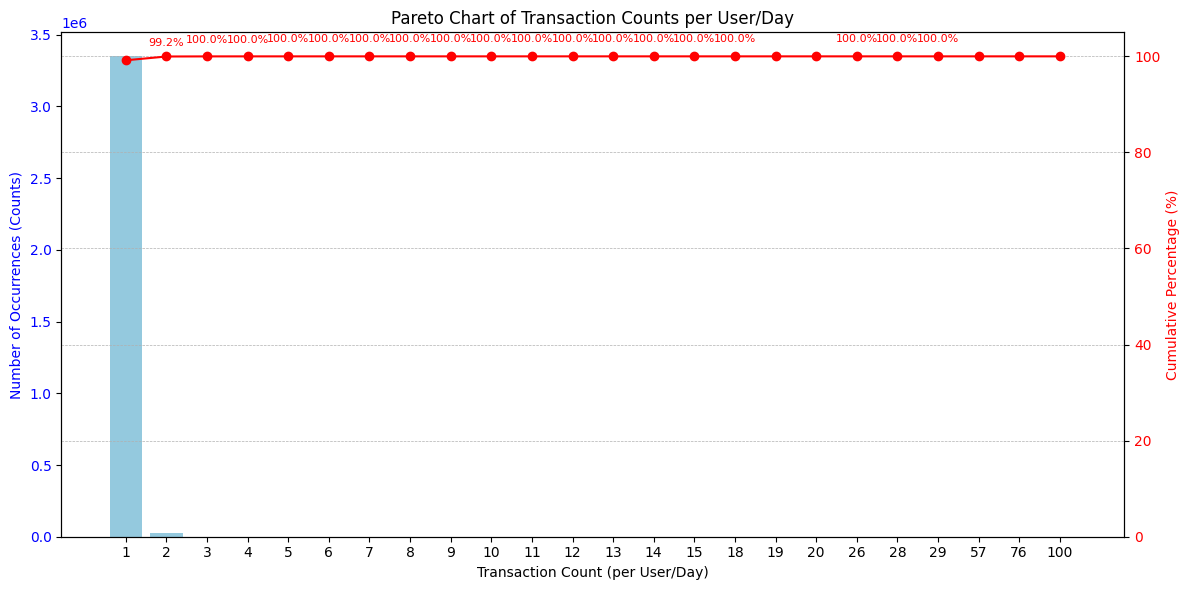

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(x='transaction_count', y='counts', data=daily_user_counts_by_transactions, ax=ax1, color='skyblue')
ax1.set_xlabel('Transaction Count (per User/Day)')
ax1.set_ylabel('Number of Occurrences (Counts)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Pareto Chart of Transaction Counts per User/Day')

ax2 = ax1.twinx()
ax2.plot(daily_user_counts_by_transactions['transaction_count'].astype(str),
         daily_user_counts_by_transactions['proportion'] * 100,
         color='red', marker='o', linestyle='-')
ax2.set_ylabel('Cumulative Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 105)

for index, row in daily_user_counts_by_transactions.iterrows():
    ax2.annotate(f'{row["proportion"]:.1%}',
                 (row['transaction_count'], row['proportion'] * 100),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')

plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [13]:
outlier_user_list = list(daily_transactions_by_user[daily_transactions_by_user['transaction_count'] > 2]['msno'].unique())
filtering = lambda x: True if x not in outlier_user_list else False
df_transactions['filtered'] = df_transactions['msno'].apply(filtering)

In [14]:
# Check proportion of records of "outlier" users
df_transactions[df_transactions['filtered'] == False].shape[0] / df_transactions.shape[0]

0.004605765118015208

In [ ]:
df_transactions = df_transactions[df_transactions['filtered'] == True]
df_transactions = df_transactions.drop(columns=['filtered'])

In [ ]:
df_transactions = df_transactions[df_transactions['membership_expire_date'] >= '2015-01-01']

In [ ]:
df_transactions = df_transactions.reset_index(drop=True)

In [61]:
df_transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-01-08,2015-02-09,0
1,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-02-08,2015-03-09,0
2,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-03-08,2015-04-09,0
3,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-04-08,2015-05-09,0
4,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,0,0,149,1,2015-05-04,2015-06-04,1


In [ ]:
# Create silver table and store to Google Cloud Storage
siver_transactions_file_path = "Silver Layer/silver_transactions.csv"
silver_transactions_gcs_path = f"gs://{bucket_name}/{siver_transactions_file_path}"

try:
    df_transactions.to_csv(silver_transactions_gcs_path, index=False)
    print("silver_transactions.csv Stored to Silver Layer Successfully! ✅")
except Exception as e:
    print(f"silver_transactions.csv Store Failed: {e}")

silver_transactions.csv Stored to Silver Layer Successfully! ✅


## EDA

In [18]:
result_rows = []

grouped = df_transactions.groupby('msno', sort=False)
for msno, group in tqdm(grouped, total=len(grouped)):
    group = group.reset_index(drop=True)

    for i in range(len(group)):
        row = group.iloc[i]

        expire_date = row['membership_expire_date']
        payment_plan_days = row['payment_plan_days']

        if 30 <= payment_plan_days <= 31 and row['is_cancel'] == 0:

            next_transaction_date = None
            days_diff = None
            for j in range(i + 1, len(group)):
                next_row = group.iloc[j]
                if next_row['is_cancel'] == 0:
                    next_transaction_date = next_row['transaction_date']
                    days_diff = (next_transaction_date - expire_date).days
                    break

            membership_start_date = expire_date - pd.to_timedelta(payment_plan_days, unit='D')

            result_rows.append({
                'msno': row['msno'],
                'membership_start_date': membership_start_date,
                'membership_expire_date': expire_date,
                'next_transaction_date': next_transaction_date,
                'days_diff': days_diff,
            })

df_result = pd.DataFrame(result_rows)
df_result.loc[df_result['days_diff'] < 0, 'days_diff'] = 0

100%|██████████| 188874/188874 [15:01<00:00, 209.57it/s]


In [30]:
df_result[df_result['days_diff'] == 0].sample(5)

,msno,membership_start_date,membership_expire_date,next_transaction_date,days_diff
1460337,SzVS/T64bwISs7Lgo4iVbNAkMo+CPbS+8pF9S/hFEaU=,2016-08-02,2016-09-01,2016-08-31,0.0
648165,BlLNSFkADfZoIMDQPQvnnxANRtXr6HF6cFk846kTMZQ=,2015-09-03,2015-10-03,2015-10-03,0.0
303798,4VFrDVujr7YQYJ44Gywk4d6muqIVJUHGNjkNyDlnuYg=,2016-05-13,2016-06-12,2016-06-12,0.0
2123469,h1TY/8o1e6bNzQ2dsXiMk1MF/kF3Yrkf4lWaPjnR0Ek=,2015-08-14,2015-09-13,2015-09-13,0.0
1689670,XrsNMNvHRv4XDxNa5CEb3zsSgnQubYhQI+0ekUcG/S8=,2016-01-24,2016-02-23,2016-02-22,0.0


In [38]:
df_result[df_result['days_diff'] > 0].sample(5)

,msno,membership_start_date,membership_expire_date,next_transaction_date,days_diff
136122,0rMhiZYx/GSaCVGhNYOOVIlTP7Q595u+KA1xYxSDptg=,2015-09-20,2015-10-20,2016-01-08,80.0
1913348,ch7Tp/YEzorywA8gpPDq5V0GLcGUnFoQzhrA/KOLH3w=,2015-11-27,2015-12-27,2015-12-28,1.0
397097,6SbKhRgfTlD7vV/vU95JJnZFRnCI4m4xotTuW92W+TQ=,2016-09-18,2016-10-18,2016-10-19,1.0
2052422,fZe930/ySmJFG/219x0c039u3io2xhDySwV7A15MRfA=,2015-01-12,2015-02-12,2015-06-02,110.0
2835700,w9DzrtmNI7hUozneKwyAuWg0r5j2rsflOMB51stgg6w=,2015-04-01,2015-05-02,2015-05-03,1.0


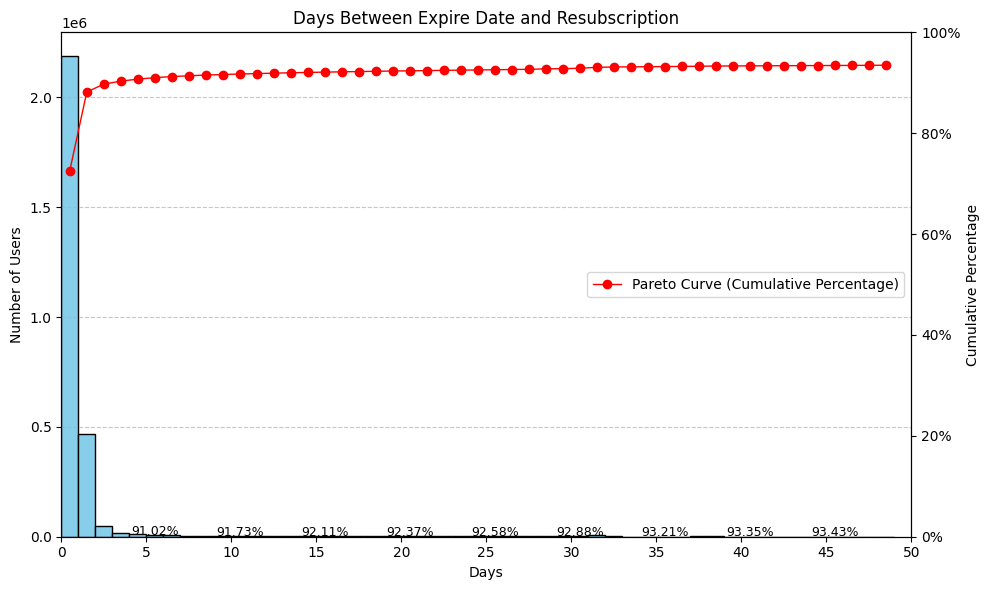

In [46]:
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_result['days_diff'], bins=range(0, 50), color='skyblue', edgecolor='black')

plt.xlim(0, 50)
plt.xticks(range(0, 51, 5))
plt.title('Days Between Expire Date and Resubscription')
plt.xlabel('Days')
plt.ylabel('Number of Users')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

total_count = len(df_result)
x_ticks_to_label = [5, 10, 15, 20, 25, 30, 35, 40, 45]

for x in x_ticks_to_label:
    if x >= len(bins):
        continue

    count_less_than_x = df_result[df_result['days_diff'] <= x].shape[0]
    proportion = count_less_than_x / total_count

    bin_index = x
    patch = patches[bin_index]

    height = patch.get_height()
    bin_center = 0.5 * (bins[bin_index] + bins[bin_index + 1])

    plt.text(
        bin_center,
        height + 1000,
        f'{proportion:.2%}',
        ha='center',
        fontsize=9,
        rotation=0
    )

ax2 = plt.twinx()
cumulative_n = n.cumsum()
cumulative_percentage = cumulative_n / total_count
bin_centers = (bins[:-1] + bins[1:]) / 2
ax2.plot(bin_centers, cumulative_percentage, color='red', marker='o', linestyle='-', linewidth=1, label='Pareto Curve (Cumulative Percentage)')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Cumulative Percentage')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
lines, labels = ax2.get_legend_handles_labels()
plt.legend(lines, labels, loc='center right')

plt.tight_layout()
plt.show()

## Gold Layer

In [56]:
grace_period = 5
df_result['churn'] = ((df_result['days_diff'] > grace_period) | (df_result['days_diff'].isna())).astype(int)

In [57]:
df_labels = df_result[["msno", "membership_start_date", "membership_expire_date", "churn"]]

In [68]:
df_labels.sample(5)

,msno,membership_start_date,membership_expire_date,churn
1297022,PWh8KBL9qJG+/SAn/Rzx8XiO+xKxcqD0Yzwg57TmnBY=,2015-08-12,2015-09-11,0
1064376,KYfAE25nOoFtOrCaJaqxXXd12ukmokYoPpfoqmRz204=,2015-06-11,2015-07-11,0
2495903,ozOtyrB/wqb3QnA+g71Vdyp/O55P8dn2O753YL2+10Y=,2016-03-14,2016-04-13,0
840867,FuN1N9jBgzZ9PN6AjZjWK5mtMRwD1prrQ1ry6ECiYIg=,2016-07-13,2016-08-12,0
1515347,U7mJhNtcNrNuZcpw5oYAcdnU7ecKdukywuur0t9acUk=,2017-03-31,2017-04-30,1


Proportion of 0s: 0.910
Proportion of 1s: 0.090


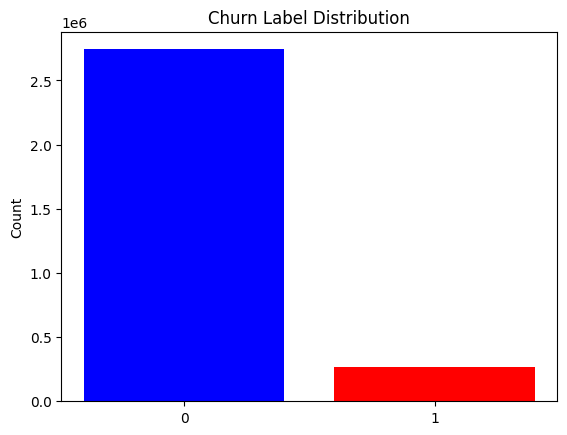

In [62]:
churn_counts = df_labels['churn'].value_counts().sort_index()
churn_proportions = df_labels['churn'].value_counts(normalize=True).sort_index()

print(f"Proportion of 0s: {churn_proportions.iloc[0]:.3f}")
print(f"Proportion of 1s: {churn_proportions.iloc[1]:.3f}")

plt.bar(churn_counts.index, churn_counts.values, color=['blue', 'red'])
plt.ylabel('Count')
plt.xticks([0, 1])
plt.title('Churn Label Distribution')
plt.show()

In [69]:
# Create gold table and store to Google Cloud Storage
gold_label_file_path = "Gold Layer/labels.csv"
gold_label_gcs_path = f"gs://{bucket_name}/{gold_label_file_path}"

try:
    df_labels.to_csv(gold_label_gcs_path, index=False)
    print("labels.csv Stored to Gold Layer Successfully! ✅")
except Exception as e:
    print(f"labels.csv Store Failed: {e}")

labels.csv Stored to Gold Layer Successfully! ✅
